# Machine Learning Pipeline - Exploratory Data Analysis


1. **Exploratory Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Trainng
5. Obtaining Predictions / Scoring

======================================================================================================================
## Predicting Building Energy Usage

The aim of the project is to develop an accurate model of metered building energy usage in such areas as chilled water, electric, hot water, and steam meters based on historic usage rates and observed weather over a three-year timeframe.

### Why is this important? 

Predicting building energy usage can help to understand if the improvement of building efficiencies brings positive impact. With better estimates of these energy-saving investments, investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies that will help to reduce future energy costs and emissions.

### What is the objective of the machine learning model?

We aim to minimise the difference between the real energy consumption and the energy usage estimated by our model. Model performance is estimated with the:

1. Root Mean Squared Logarithmic Error (main)

2. Mean Squared error (mse)

3. Root Squared of the mean squared error (rmse)

4. R-squared (r2)

======================================================================================================================


## Data

Data is taken from the Kaggle Competition: https://www.kaggle.com/competitions/ashrae-energy-prediction/.

It consists of the following files:

#### train.csv

- **building_id** - Foreign key for the building metadata.
- **meter** - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- **timestamp** - When the measurement was taken
- **meter_reading** - The target variable. Energy consumption in kWh (or equivalent).

#### building_meta.csv

- **site_id** - Foreign key for the weather files.
- **building_id** - Foreign key for train.csv
- **primary_use** - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- **square_feet** - Gross floor area of the building
- **year_built** - Year building was opened
- **floor_count** - Number of floors of the building

#### weather_[train/test].csv

Weather data from a meteorological station as close as possible to the site.

- **site_id**
- **air_temperature** - Degrees Celsius
- **cloud_coverage** - Portion of the sky covered in clouds, in oktas
- **dew_temperature** - Degrees Celsius
- **precip_depth_1_hr** - Millimeters
- **sea_level_pressure** - Millibar/hectopascals
- **wind_direction** - Compass direction (0-360)
- **wind_speed** - Meters per second

#### test.csv 

- **row_id** - Row id for the submission file
- **building_id** - Building id code
- **meter** - The meter id code
- **timestamp** - Timestamps for the test data period

======================================================================================================================

Target variable is **meter_reading** from train.csv.

## 1. Loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
building = pd.read_csv('data/building_metadata.csv')
weather_train = pd.read_csv('data/weather_train.csv')

print('train:', train.shape)
print('building_metadata:', building.shape)
print('weather_train:', weather_train.shape)

train: (20216100, 4)
building_metadata: (1449, 6)
weather_train: (139773, 9)


In [3]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


### 1.1 Merging the data

In [6]:
print('Number of unique buildings in the dataset:', len(train['building_id'].unique()))
print('Number of unique sites:', len(building['site_id'].unique()))

Number of unique buildings in the dataset: 1449
Number of unique sites: 16


In [7]:
assert sorted(list(train['building_id'].unique())) == list(building['building_id'].unique())
assert sorted(list(building['site_id'].unique())) == list(weather_train['site_id'].unique())
assert sorted(list(train['timestamp'].unique())) == list(weather_train['timestamp'].unique())

print('All unique primary keys in datasets fit to each other. So there is no problem to merge data sources.')

All unique primary keys in datasets fit to each other. So there is no problem to merge data sources.


In [8]:
data = train.merge(building, on = 'building_id', how = 'left')
data = data.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')

print(data.shape)

data.head()

(20216100, 16)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


### 1.2 Converting timestamp into year, month, day, time

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [10]:
assert data['timestamp'].dt.minute.unique() == [0]
assert data['timestamp'].dt.second.unique() == [0]
assert data['timestamp'].dt.year.unique() == [2016]

print('Time records have only hours as unique values. Year is 2016 for all the records. So we can leave month, day and hour as features.')

Time records have only hours as unique values. Year is 2016 for all the records. So we can leave month, day and hour as features.


In [11]:
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['hour'] = data['timestamp'].dt.hour

In [12]:
print(data.shape)
data.head(2)

(20216100, 19)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,hour
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,0


In [13]:
from sklearn.model_selection import train_test_split

# train and test sets
X, Xtest, y, ytest = train_test_split(data.drop('meter_reading', axis = 1), data['meter_reading'], \
                                      test_size=0.15, random_state=0, shuffle = True)

# train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=0, shuffle = False)

X_train['meter_reading'] = y_train
data = X_train.copy()
data = data.sort_values(by = 'timestamp', ascending = True)

## 2. Analysis 

**We will conduct following analysis**:

1. Target variable
2. Missing data
3. Variable types (categorical and numerical)
4. Categorical Variables
    - Cardinality
    - Rare Labels
    - Distribution

5. Discrete variables

6. Continious variables

    
    
### 2.1. Target variable

In [14]:
# exploring target distribution

data['meter_reading'].describe()

print('{}% of the records in data set have zero value.'.format(round(len(data[data['meter_reading'] == 0]) / len(data['meter_reading']) * 100),2))

9% of the records in data set have zero value.


75% of the whole target variable lays below 268. And there are some very high values as 2*10^7.

Distribution of energy usage for three random buildings


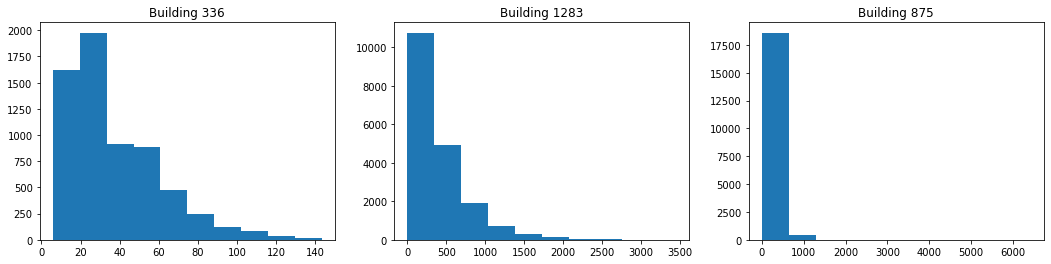

In [15]:
random_id = np.random.randint(0, len(data['building_id'].unique()), 3)

print('Distribution of energy usage for three random buildings')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

for i, ax in enumerate(axs.flatten()):
    ax.hist(data[data['building_id']== random_id[i]]['meter_reading'])
    ax.set_title('Building {}'.format(random_id[i]))
    

Energy usage vs date for three random buildings


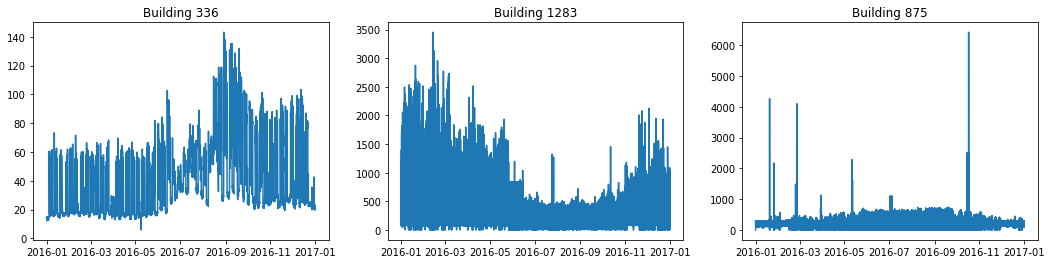

In [16]:
print('Energy usage vs date for three random buildings')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

for i, ax in enumerate(axs.flatten()):
    ax.plot(data[data['building_id']== random_id[i]]['timestamp'],data[data['building_id']== random_id[i]]['meter_reading'] )
    ax.set_title('Building {}'.format(random_id[i]))
    

<AxesSubplot:title={'center':'Mean value of the energy usage during the year'}, xlabel='timestamp'>

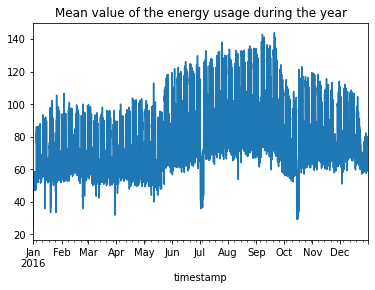

In [17]:
data.groupby('timestamp')['meter_reading'].median().plot(title = 'Mean value of the energy usage during the year')

Target "meter_reading" is time-dependent variable with a big variance. 

Let's see how target looks without zero value.

<AxesSubplot:>

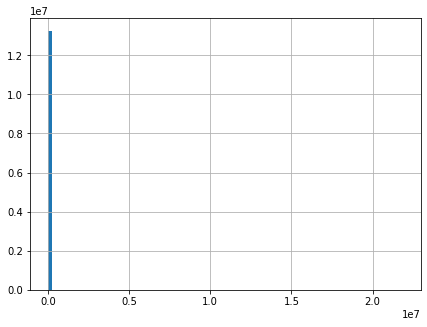

In [18]:
data['meter_reading'][data['meter_reading']!=0].hist(bins=100, figsize = (7,5))

<AxesSubplot:>

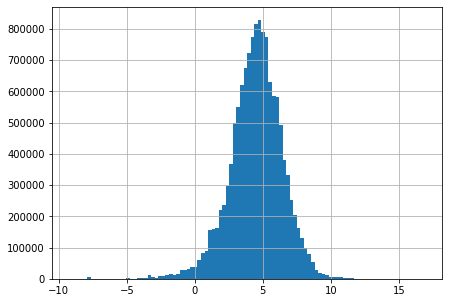

In [19]:
np.log(data['meter_reading'][data['meter_reading']!=0]).hist(bins=100, figsize = (7,5))

If we remove zero values of target variable (it is 9% of the dataset) and then make a log transformation of it we will get normay distributed variable.

In [20]:
# mode of each column

data[data['meter_reading']==0].mode()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,hour,meter_reading
0,954,1,2016-01-25 16:00:00,0,Education,387638,1968.0,2.0,19.4,0.0,17.8,0.0,1015.2,0.0,0.0,1,2,3,0.0


### 2.2. Missing Variables

In [21]:
vars_with_na = [
    var for var in data.columns
    if data[var].isnull().mean() > 0 
]

data[vars_with_na].isnull().mean().sort_values(ascending = False)

floor_count           0.826493
year_built            0.599869
cloud_coverage        0.436381
precip_depth_1_hr     0.185462
wind_direction        0.071651
sea_level_pressure    0.060945
wind_speed            0.007094
dew_temperature       0.004941
air_temperature       0.004768
dtype: float64

First four variables contain big amount of missing values.

### 2.3. Variable Types

In [22]:
data.dtypes

building_id                    int64
meter                          int64
timestamp             datetime64[ns]
site_id                        int64
primary_use                   object
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
month                          int64
day                            int64
hour                           int64
meter_reading                float64
dtype: object

In [23]:
# categorical variable

data['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Public services',
       'Entertainment/public assembly', 'Office', 'Healthcare', 'Other',
       'Food sales and service', 'Parking', 'Services', 'Utility',
       'Retail', 'Warehouse/storage', 'Technology/science',
       'Manufacturing/industrial', 'Religious worship'], dtype=object)

We have the only categorical variable "primary_use".

In [24]:
# discrete variables (<= 31 unique values (31 - max number of days in month))

discrete_vars = [var for var in data.columns if len(data[var].unique())<32 and var != 'primary_use']

print('Number of discrete variables: ', len(discrete_vars))
print(discrete_vars)

Number of discrete variables:  7
['meter', 'site_id', 'floor_count', 'cloud_coverage', 'month', 'day', 'hour']


In [25]:
# continious variables

continious_vars = [var for var in data.columns if var not in discrete_vars and var not in ['primary_use','timestamp', 'building_id', 'year_built']]

print('Number of continious variables: ', len(continious_vars))
print(continious_vars)

Number of continious variables:  8
['square_feet', 'air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'meter_reading']


In [26]:
data[continious_vars].head(2)

,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
462,57100,10.0,2.2,NaN,1021.1,350.0,4.1,29.53
736,23012,NaN,NaN,NaN,NaN,NaN,NaN,5.35


### 2.4. Categorical Variable

We have the only categorical variable "primary_use".

In [27]:
# cardinality
print('Number of unique labels is {}.'.format(len(data['primary_use'].unique())))

Number of unique labels is 16.


<AxesSubplot:xlabel='primary_use'>

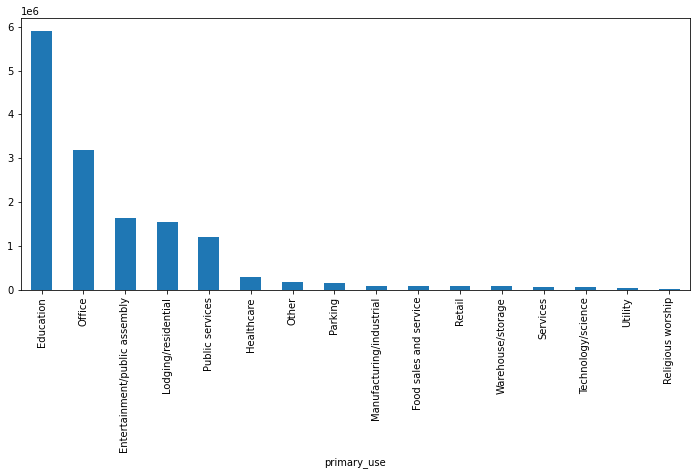

In [28]:
# distribution of labels

tmp = data.groupby('primary_use')['meter_reading'].count().sort_values(ascending=False)

tmp.plot.bar(figsize=(12,5))

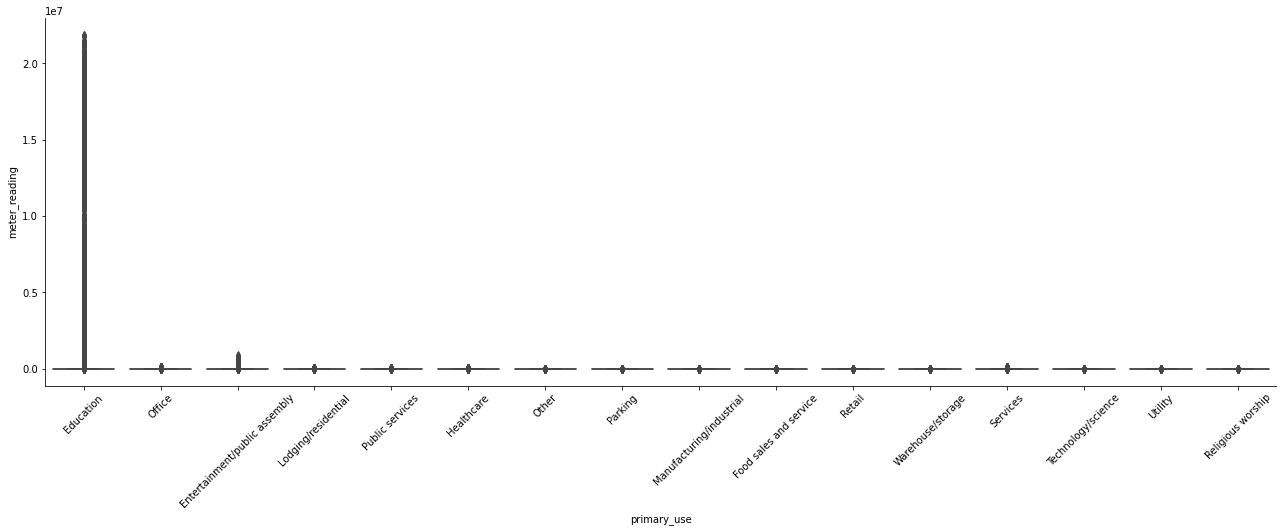

In [29]:
# target based on 'primary_use'

order = list(tmp.index)

sns.catplot(x='primary_use', y = 'meter_reading', data=data[['primary_use','meter_reading']] , order = order, kind = 'box', height = 6, aspect = 3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [30]:
# remove outliers from target variable

Q1 = data['meter_reading'].quantile(0.25)
Q3 = data['meter_reading'].quantile(0.75)
IQR = Q3-Q1

data_noout = data[~((data['meter_reading'] < (Q1 - 1.5 * IQR)) | (data['meter_reading'] > (Q3 + 1.5 * IQR)))]

print('IQR = {} \n\nDescription = \n{}'.format(IQR, data['meter_reading'].describe()))
print('\n\n\nWe removed as outliers {}% of training set.'.format(round((1-data_noout.shape[0]/data.shape[0]) * 100, 2)))

IQR = 249.567 

Description = 
count    1.460613e+07
mean     2.112574e+03
std      1.529228e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.875000e+01
75%      2.678670e+02
max      2.187450e+07
Name: meter_reading, dtype: float64



We removed as outliers 12.24% of training set.


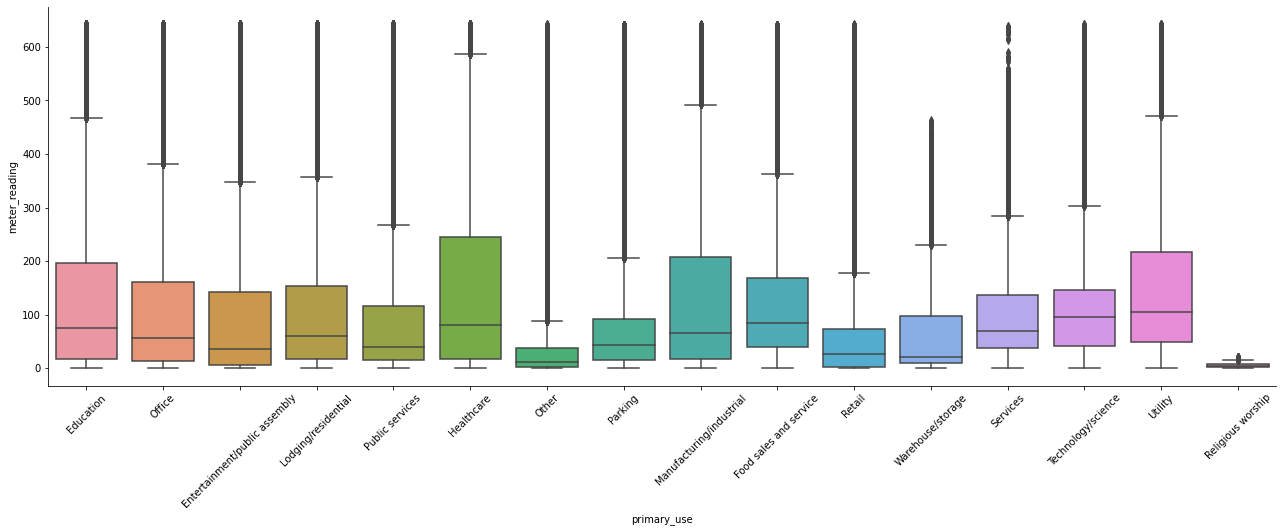

In [31]:
# target without outliers based on 'primary_use'

sns.catplot(x='primary_use', y = 'meter_reading', data=data_noout[['primary_use','meter_reading']] , order=order, kind = 'box', height = 6, aspect = 3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


- We have the only categorical variable "primary_use" which has a low cardinality (only 16 unique values).
- There are the most records corresponding to Education and Office buildings. 
- Some Education buildigns use very high amount of energy (all outliers are in this category).
- If we remove outliers the Healthcare and Manufacturing buildings use more energy than Education in general.

### 2.5. Discrete Variables

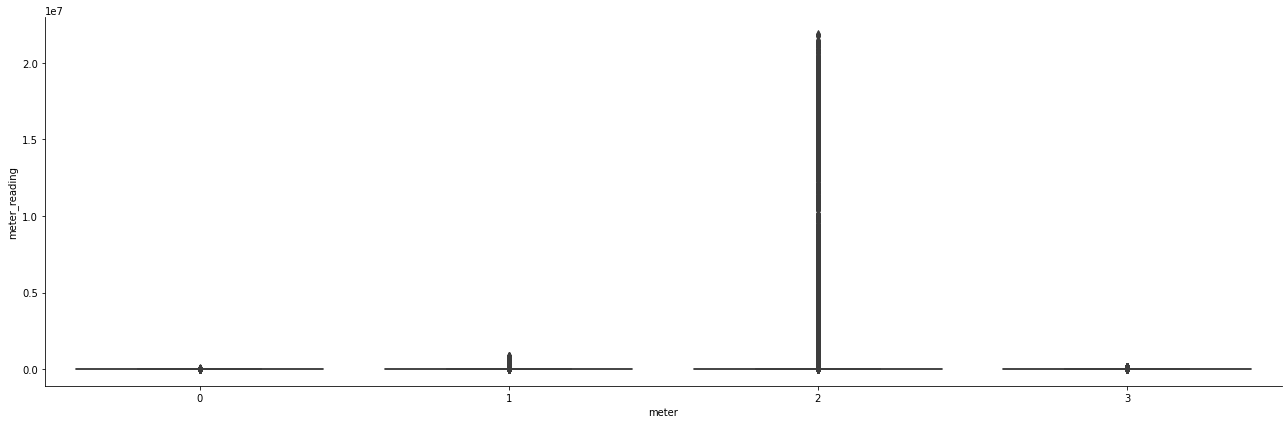

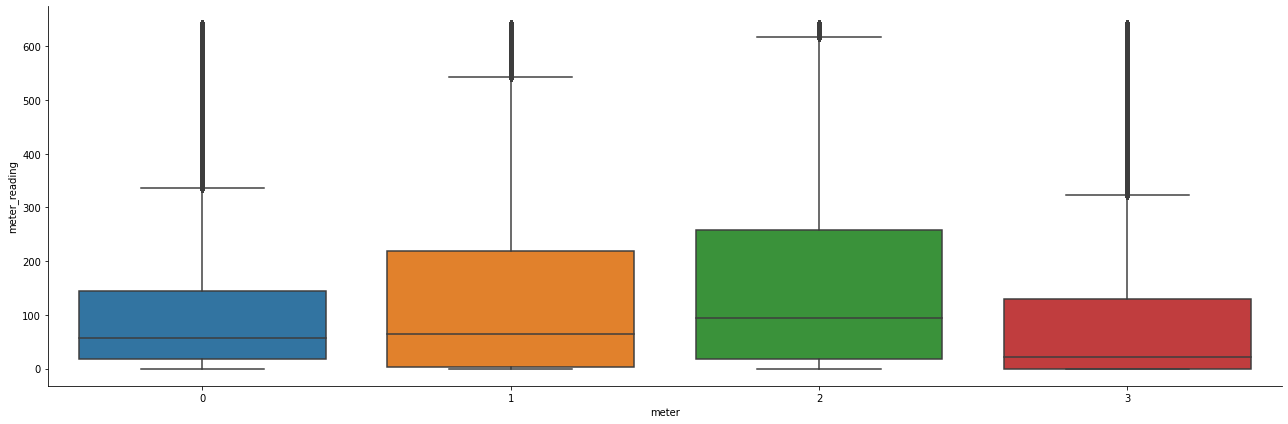

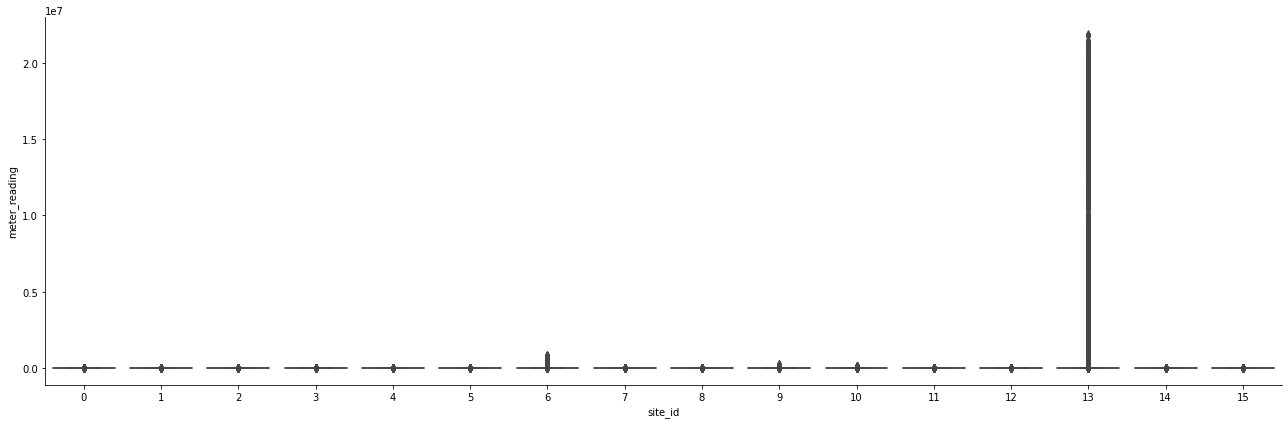

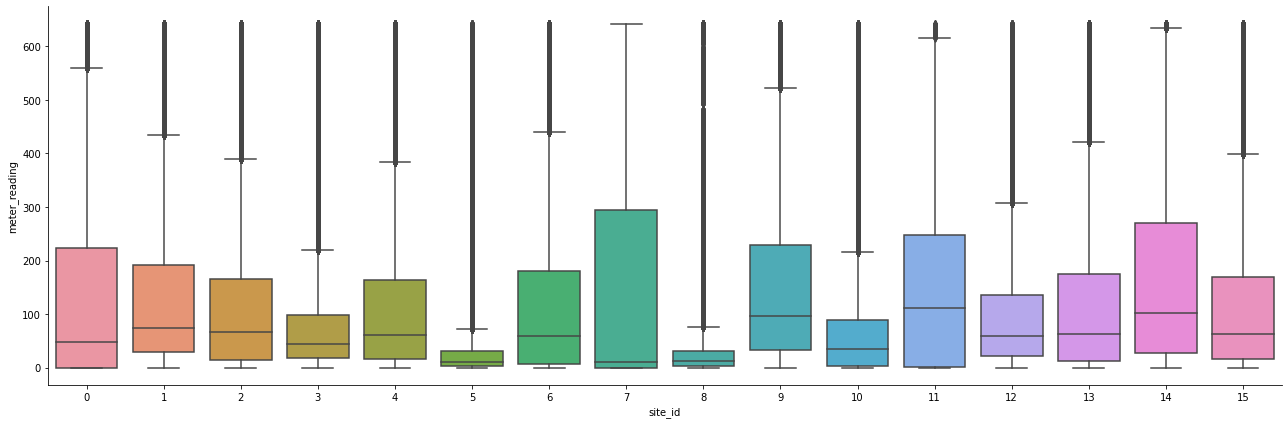

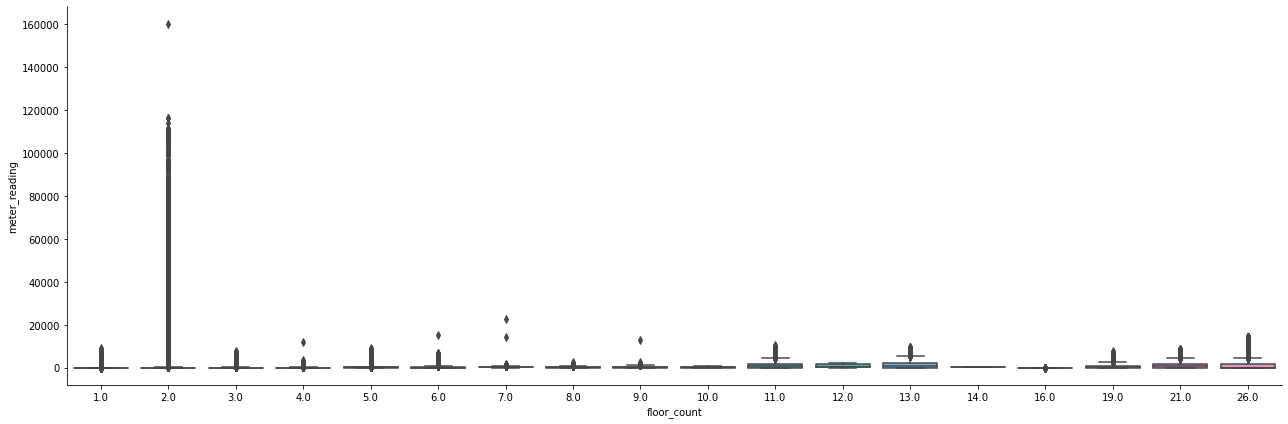

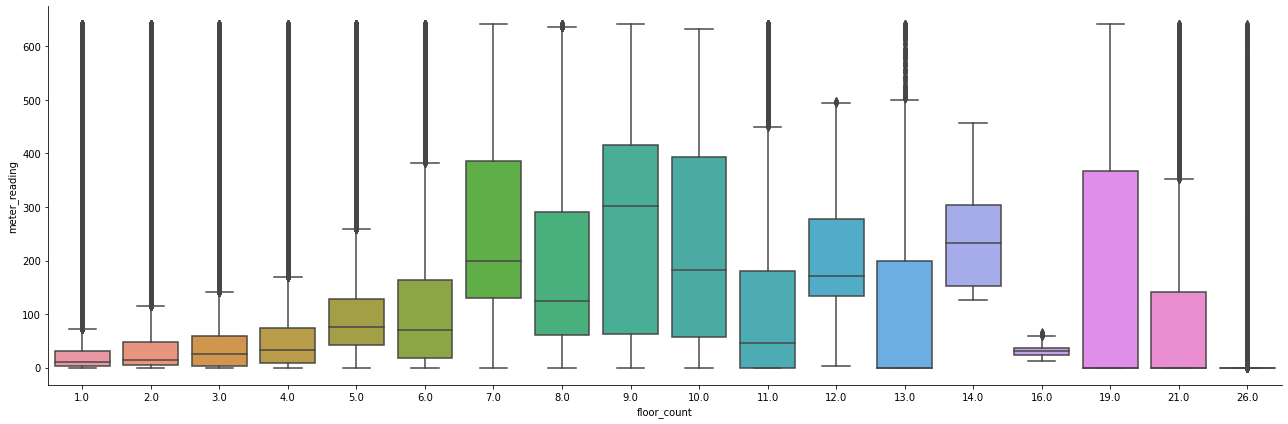

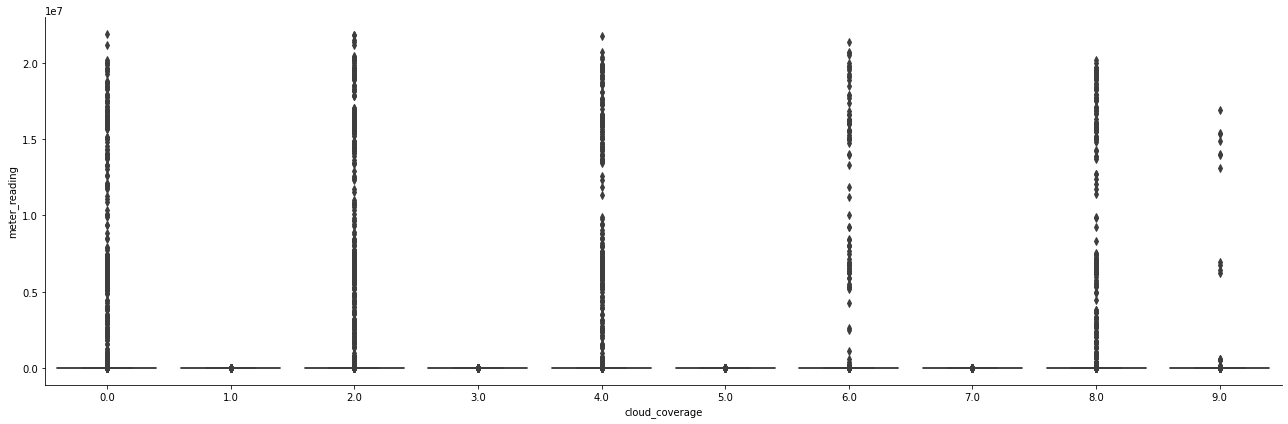

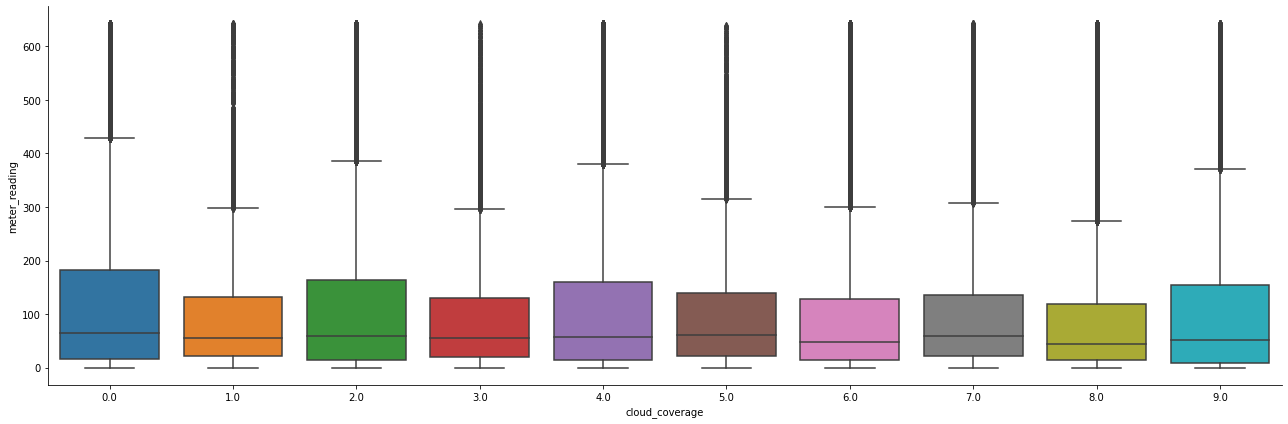

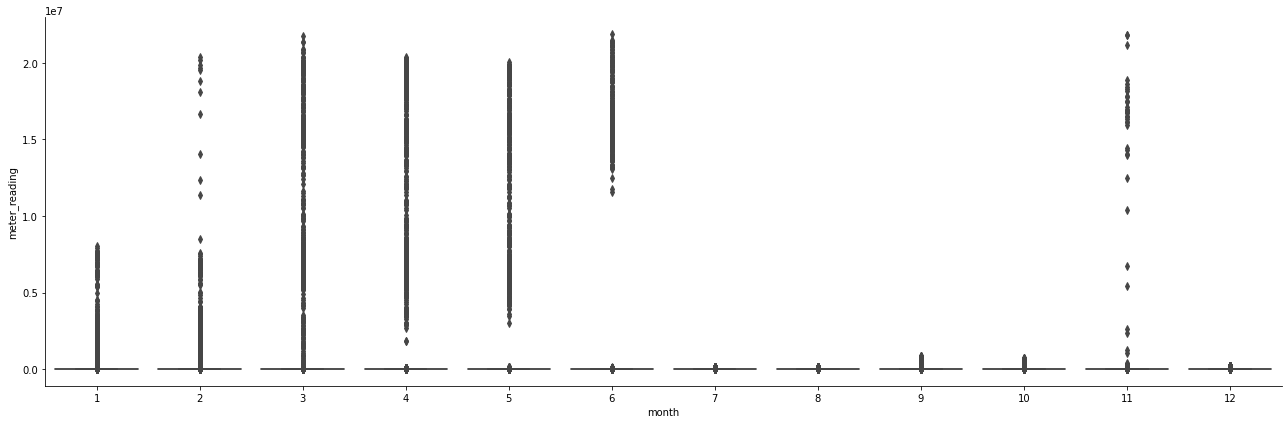

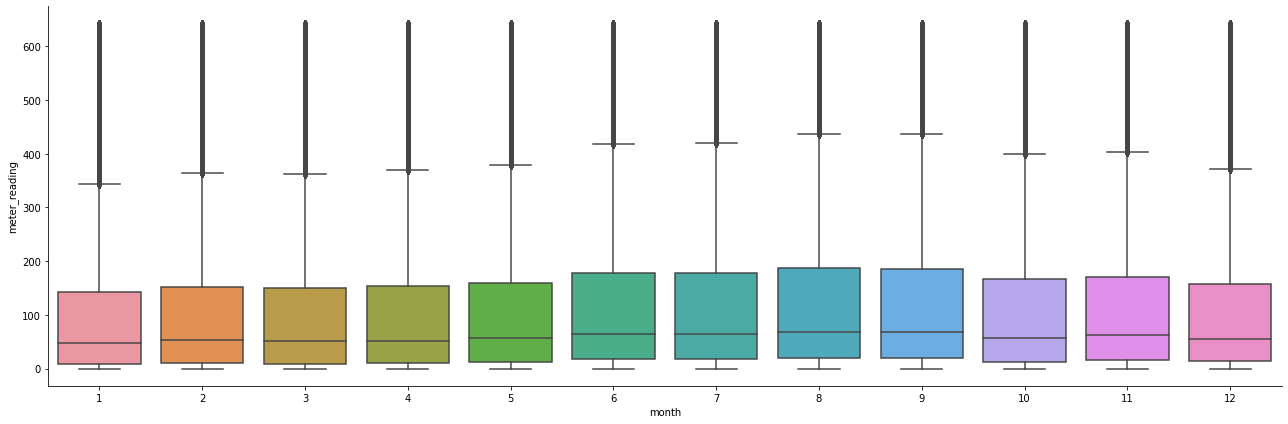

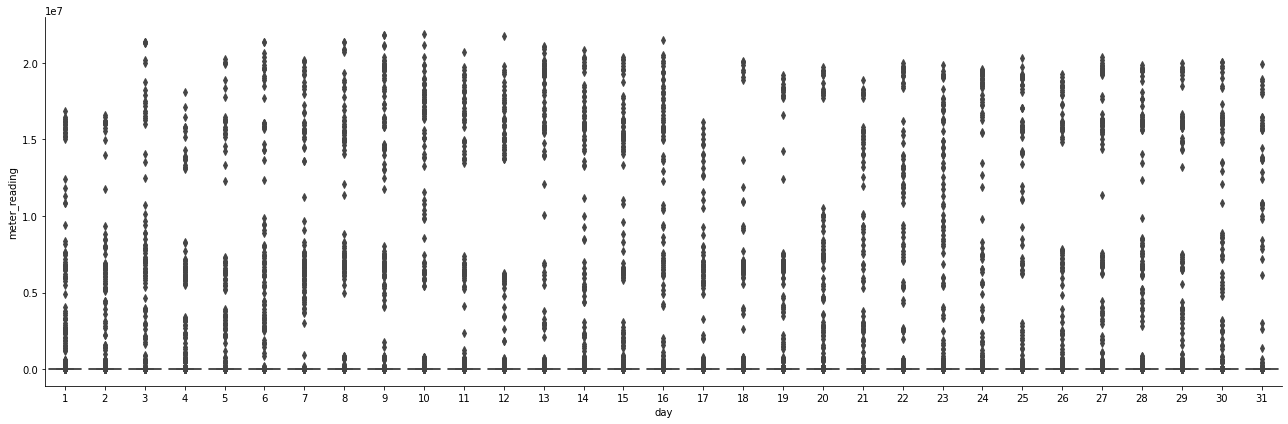

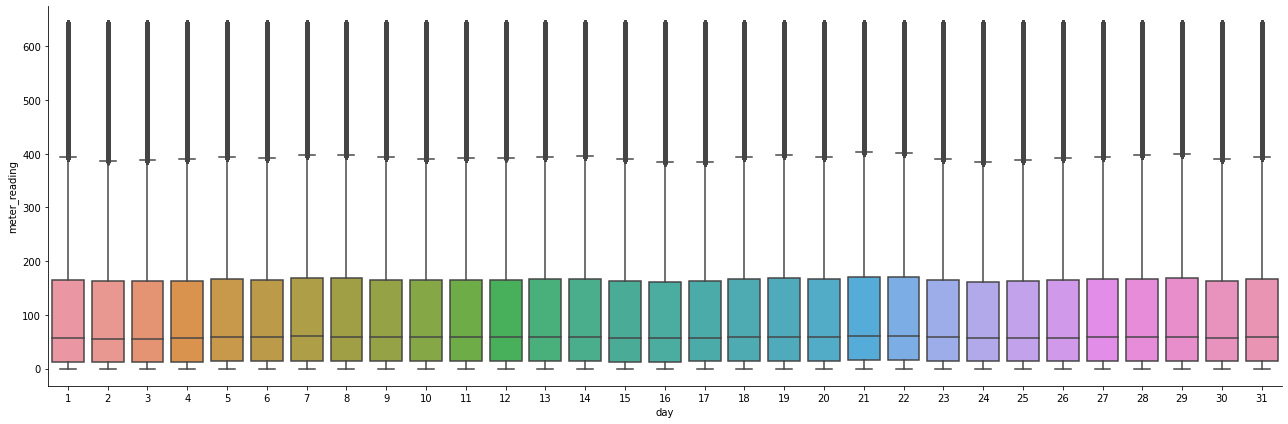

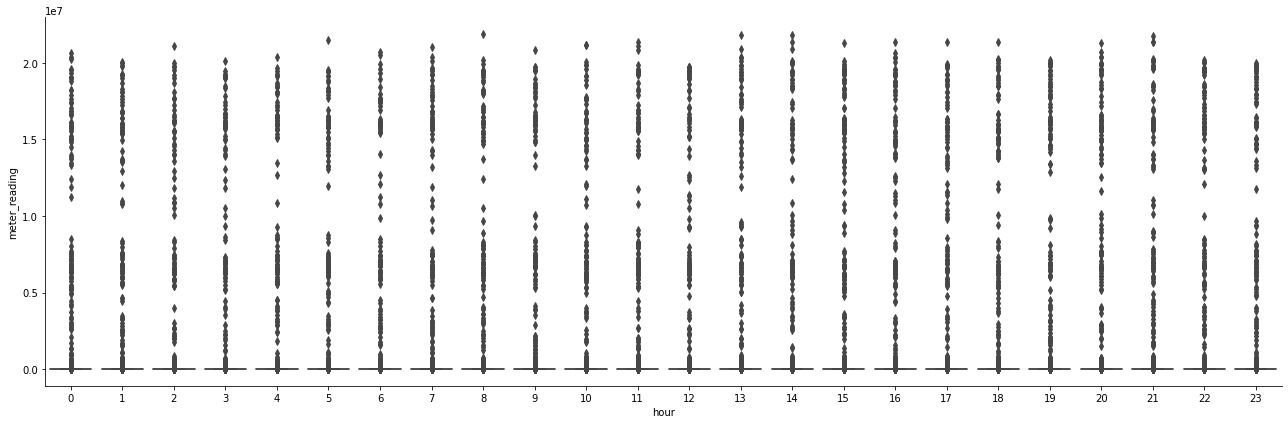

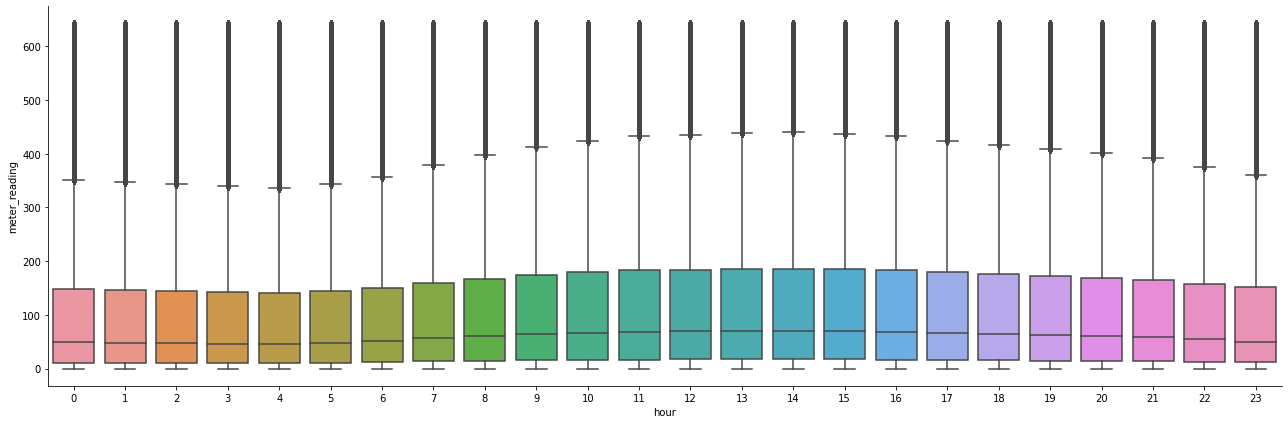

In [32]:
# target with and without outliers  based on discrete variables
for var in discrete_vars:
    
    order = list(data[var].unique()).sort()
    
    sns.catplot(x=var, y = 'meter_reading', data=data[[var,'meter_reading']], order = order, kind = 'box', height = 6, aspect = 3)
    sns.catplot(x=var, y = 'meter_reading', data=data_noout[[var,'meter_reading']], order = order, kind = 'box', height = 6, aspect = 3)
    plt.show()
        
    print('=====================================================================================================================')

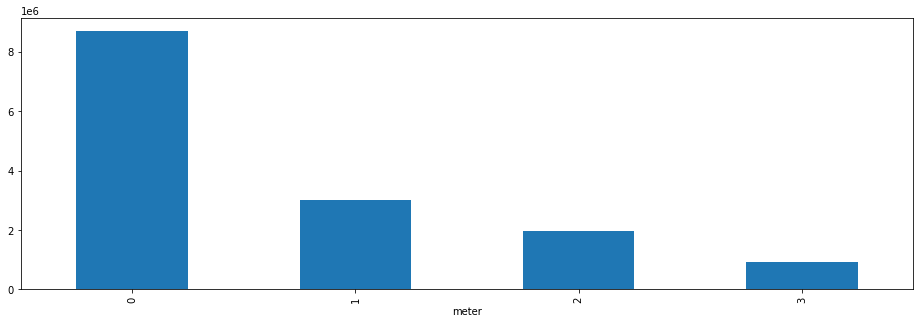

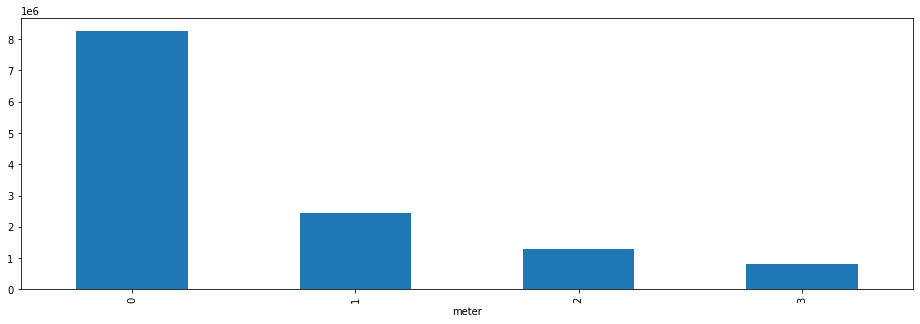

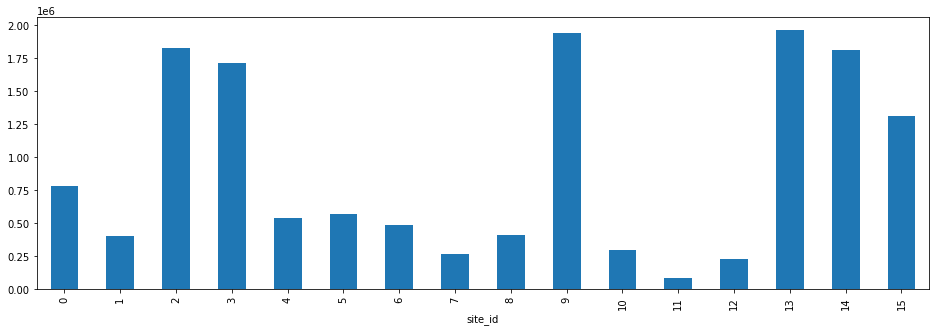

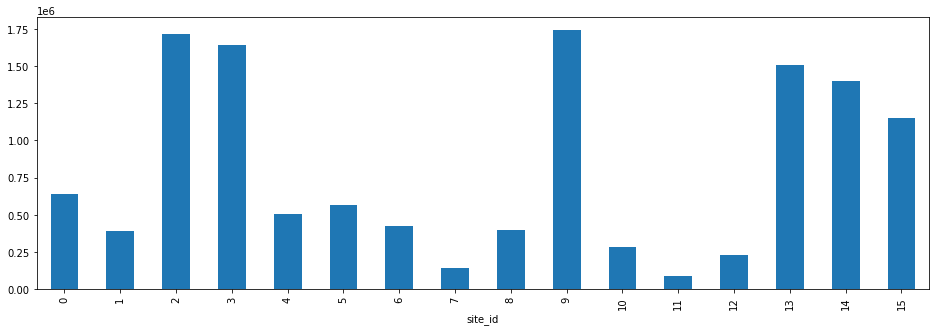

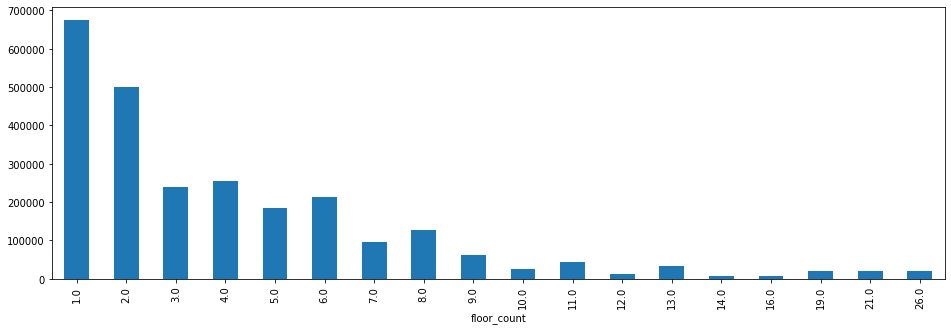

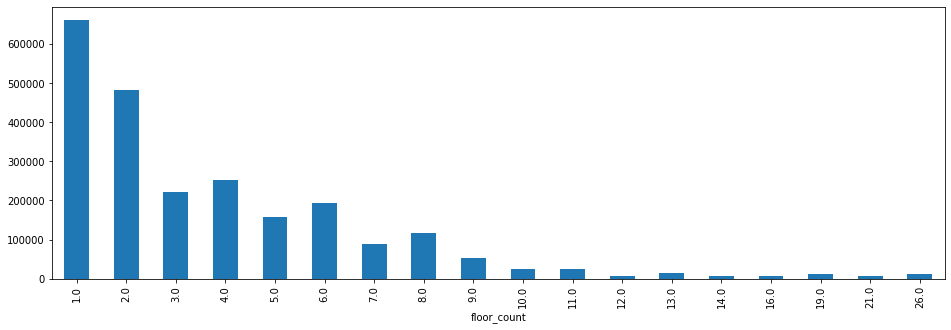

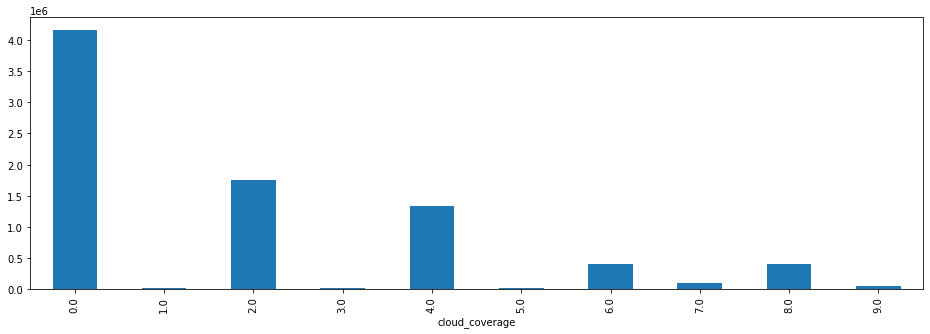

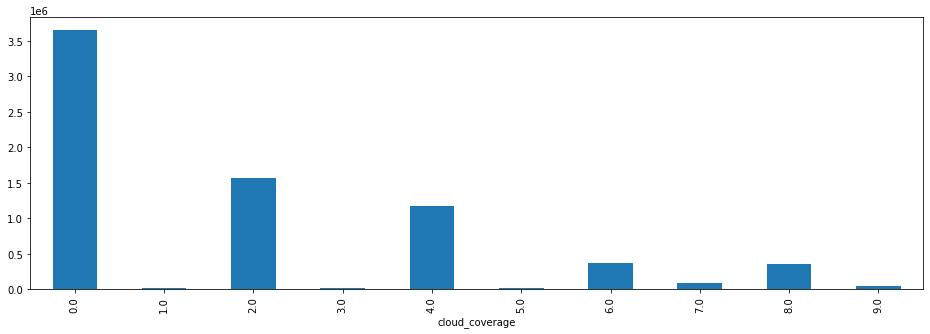

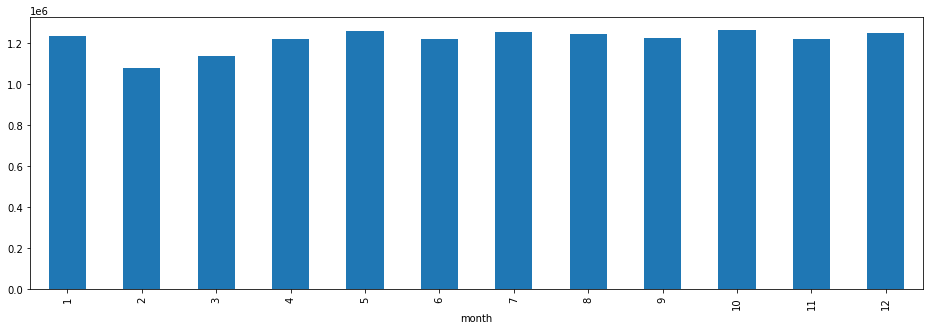

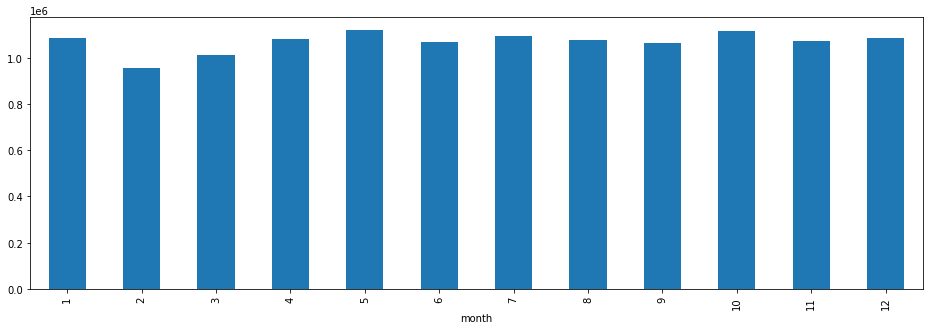

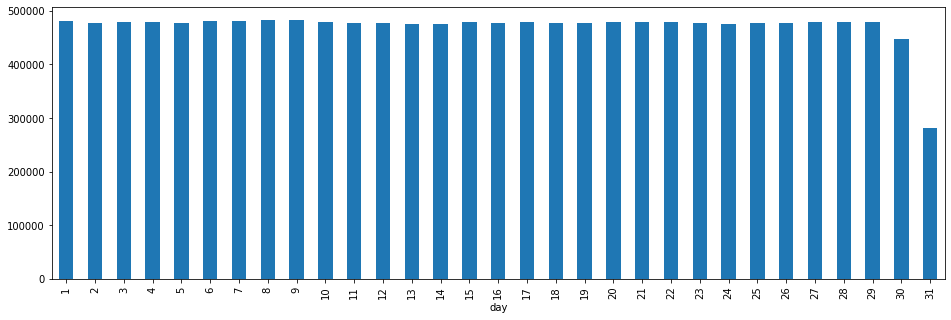

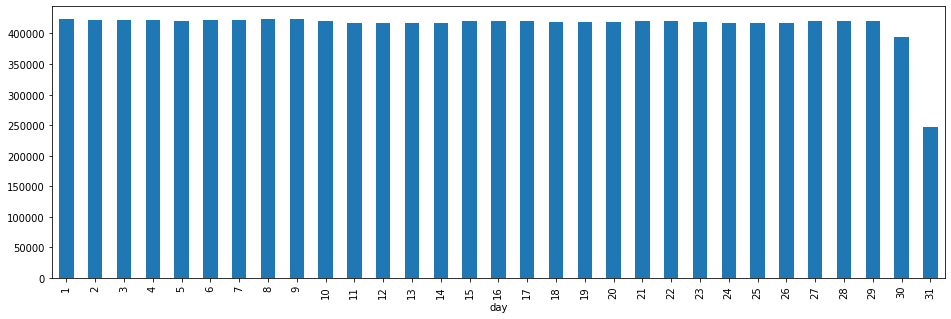

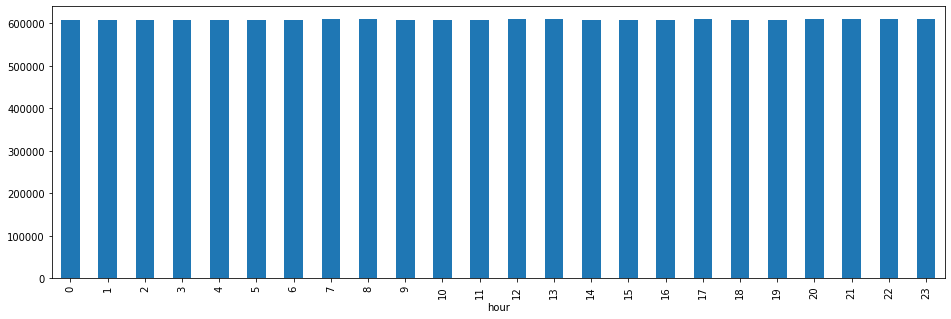

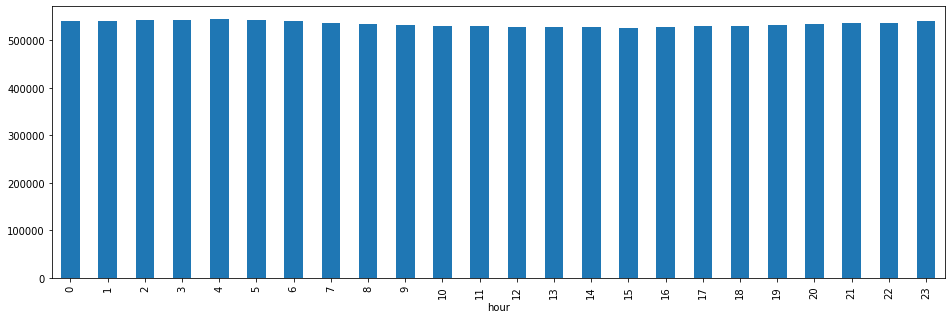

In [33]:
for var in discrete_vars:

    data.groupby(var)['meter_reading'].count().plot.bar(figsize=(16,5))
    plt.show()
    data_noout.groupby(var)['meter_reading'].count().plot.bar(figsize=(16,5))
    plt.show()
    
    print('=====================================================================================================================')

From investigating how discrete variables have influence on the target we can make following conclusions. 

**Without outliers**:

- Hotwater (2) has the highst values of energy usage. 
- Target is highly depended on site_id, location of building.
- Energy usage lineary increasing with the number of floors (as expected).
- It doesn't really depend on cloud_couverage.
- Energy usage is increasing from 6 to 9 month. Probably on cooling the buildings.
- It doesn't really depend on day of the month.
- However, during the day hours energy usage is increasing 

**Outliers**:

- Hotwater (2) has the highst values of energy usage. 
- As well as buildings which are located in site_id = 13.
- Buildings with the number of floors = 2 has the most outliers.
- Outliers have mostly even value for the cloud_coverage variable.
- Months from 7 to 9 almost don't contain outliers.
- Number of floors which is higher than 7 use much more energy
- June - September are the mounth which require the most energy usage
- It doesn't really depend on day of month
- But around 10am till 5pm during the day mean energy usage is increasing

### 2.6. Continious Variables

In [34]:
print(continious_vars)

['square_feet', 'air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'meter_reading']


In [35]:
data[continious_vars].head()

,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
462,57100,10.0,2.2,NaN,1021.1,350.0,4.1,29.530
736,23012,NaN,NaN,NaN,NaN,NaN,NaN,5.350
2174,240026,NaN,NaN,NaN,NaN,NaN,NaN,93.100
1767,268480,-8.3,-12.2,NaN,1023.3,250.0,4.1,207.964
1882,273234,NaN,NaN,NaN,NaN,NaN,NaN,2509.150


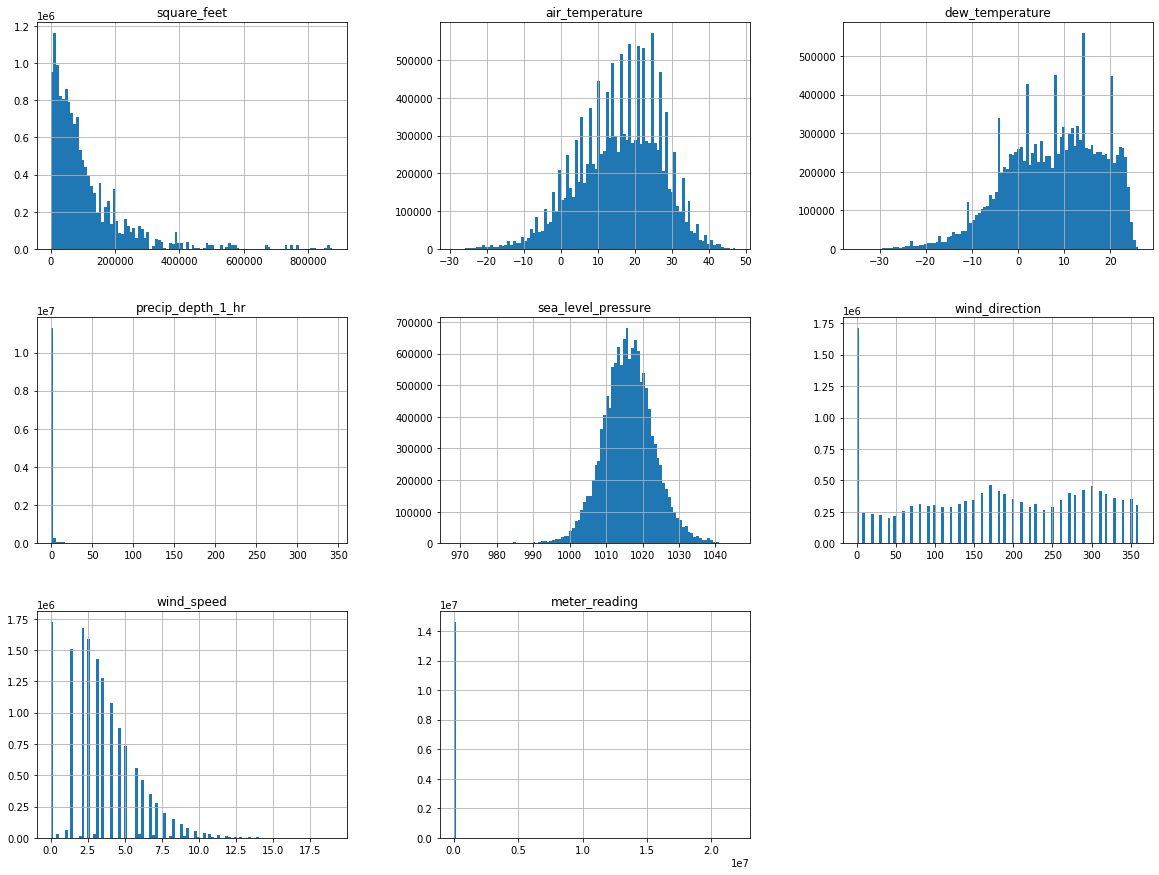

In [36]:
data[continious_vars].hist(bins = 100, figsize = (20,15))
plt.show()

<AxesSubplot:>

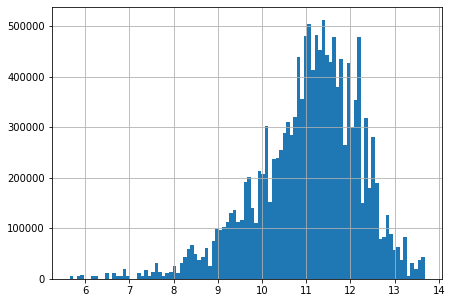

In [37]:
# logarithmic transformation of "square_feet" disitribution
np.log(data['square_feet']).hist(bins = 100, figsize = (7,5))

<AxesSubplot:>

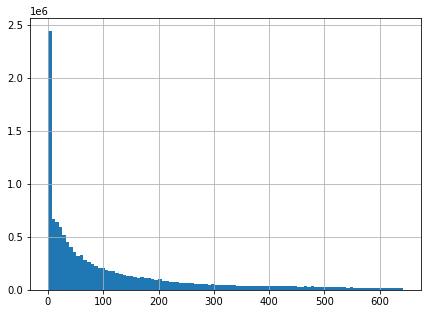

In [38]:
# distributioin of target variable without outliers

data_noout['meter_reading'].hist(bins=100, figsize = (7,5))

- Sea_level_pressure, air_temperature, dew_temperature can be described by normal distribution
- square_feet after logarithmic tranformation also can be described as normal distribution 


## 3. Other Data Dependencies

We can suppose that floor_count and average year_built highly depends on primary_use. As well as weather variables depend on month. 

If we are right we can use this information for impacting missing values in corresponded categories.

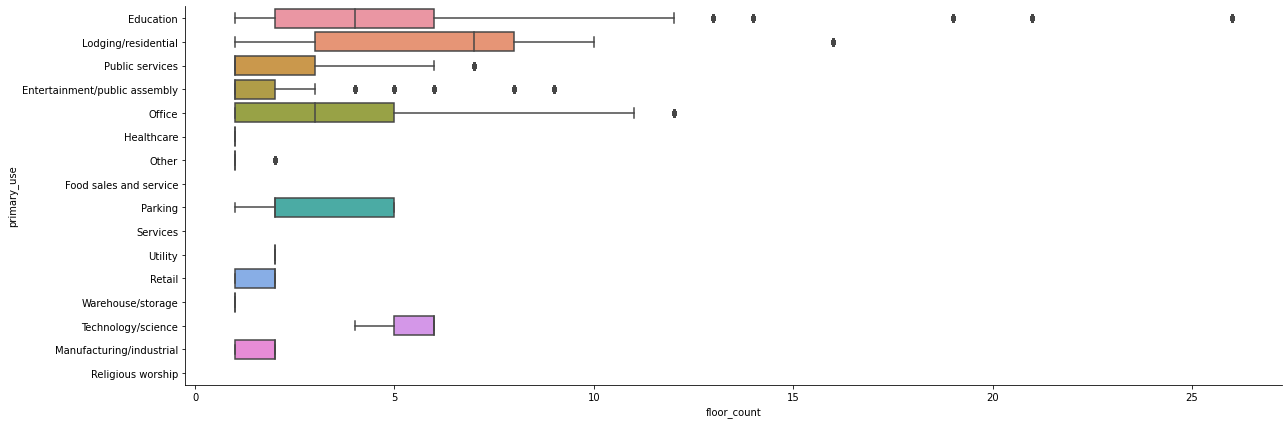

In [39]:
# floor_count vs primary_use

sns.catplot(x='floor_count', y = 'primary_use', data=data[['primary_use','floor_count']],  kind = 'box', height = 6, aspect = 3)
plt.tight_layout()

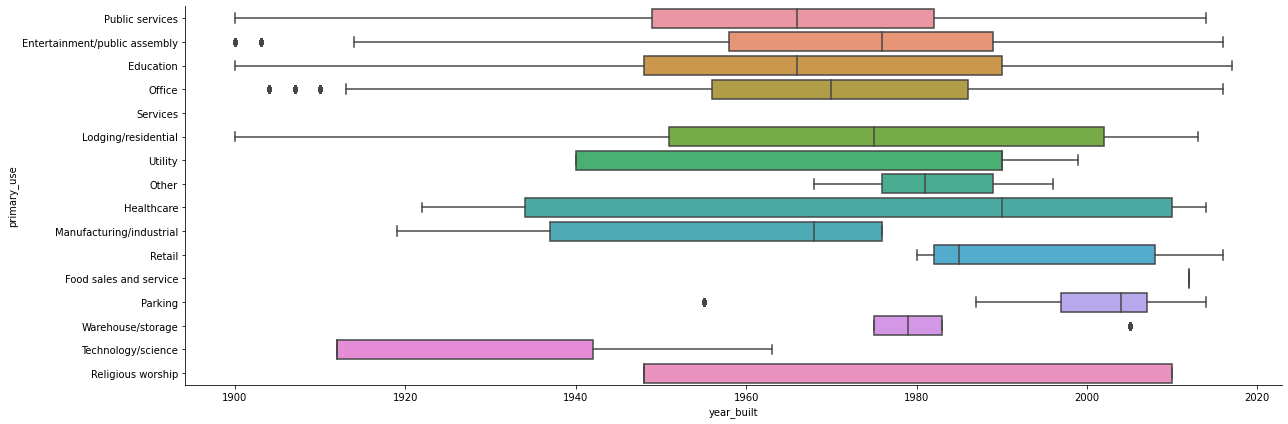

In [40]:
# floor_count vs primary_use

sns.catplot(x='year_built', y = 'primary_use', data=X_train[['primary_use','year_built']],  kind = 'box', height = 6, aspect = 3)
plt.tight_layout()

From or analysis we can observe logical results:

   - Retail, Religious worships, Entertainment, Healthcare buildings has usually less then 3 floors.
   - Residences, Education and Office buildings has the highest number of floors, sometime with very high values.
    

   - Science buildings were build in first half of last centure. Manufactures  - till the 1980.
   - Parking places mostly in 21 centure.
   - All storage buuldings were build around 1980 year.
   - After this Reatil buildings started to be built. 

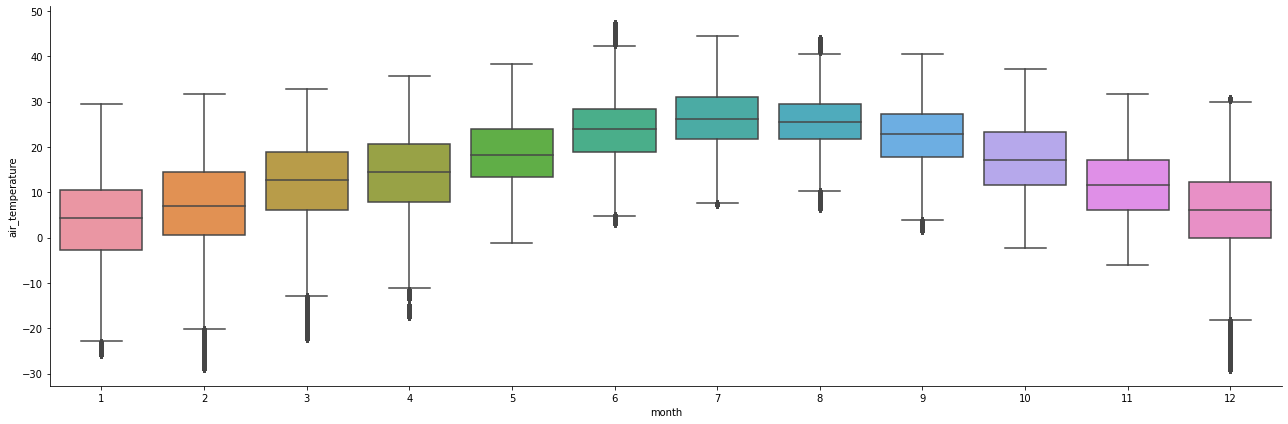

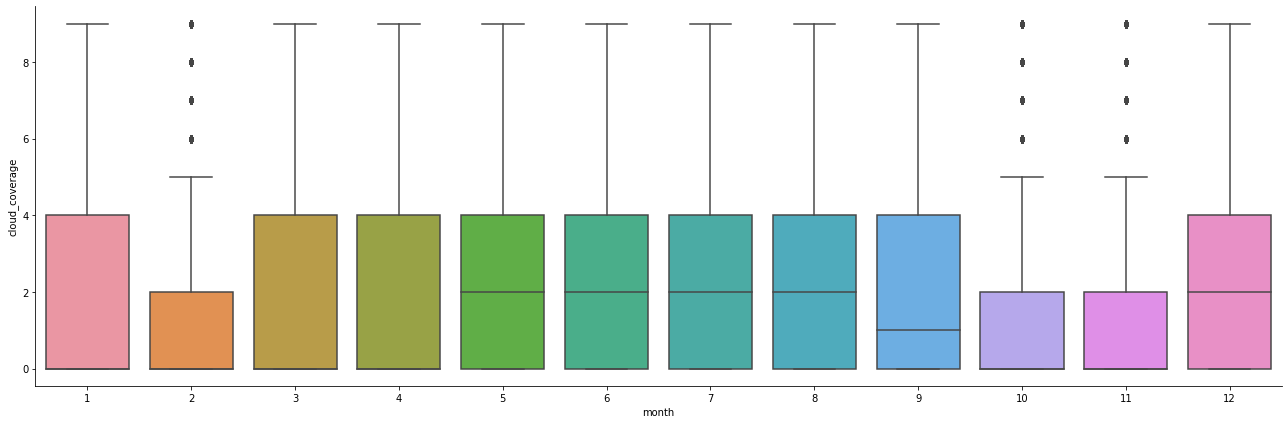

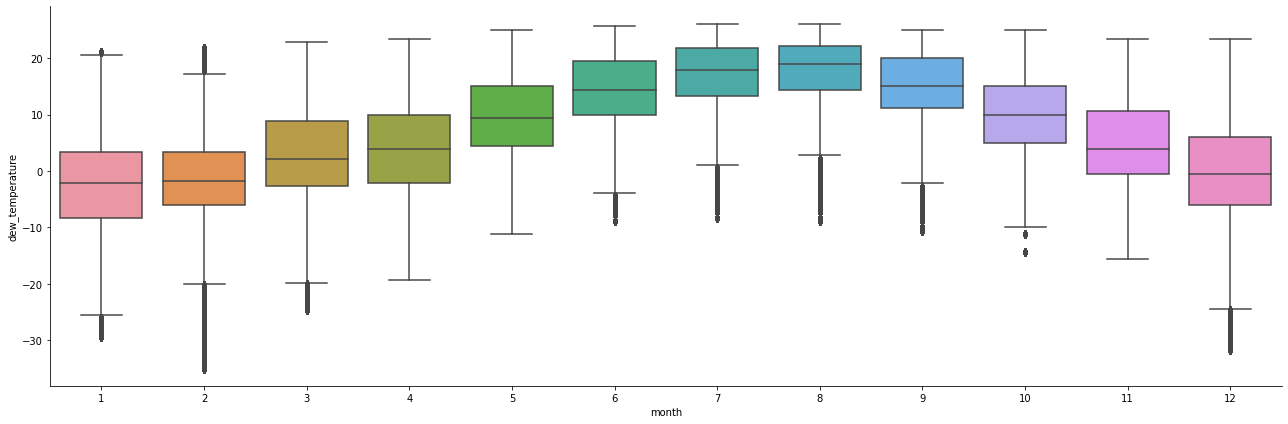

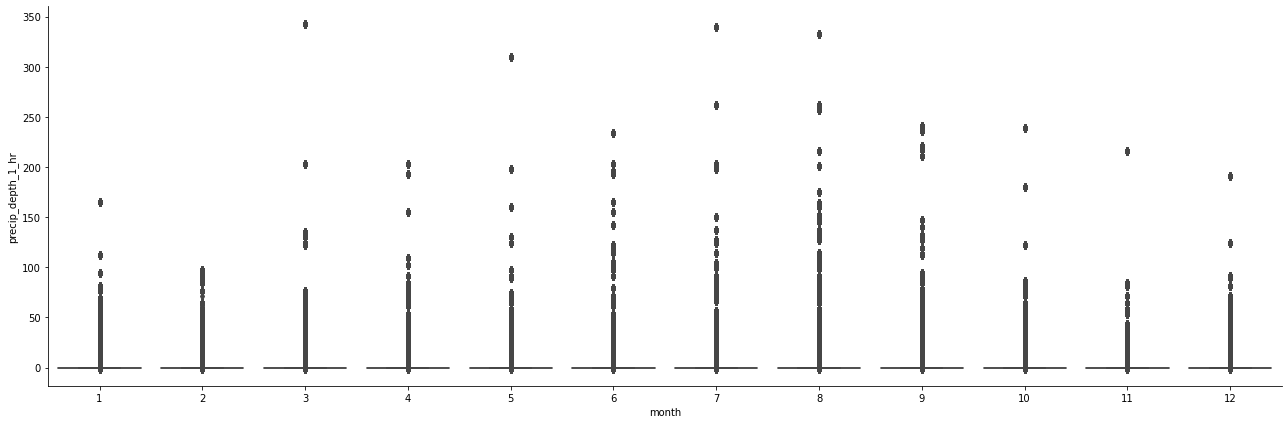

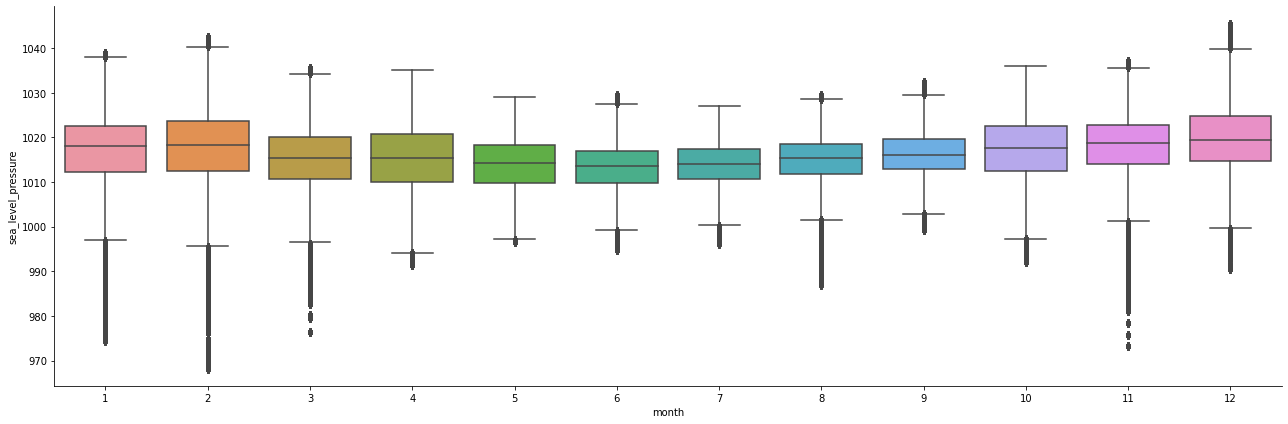

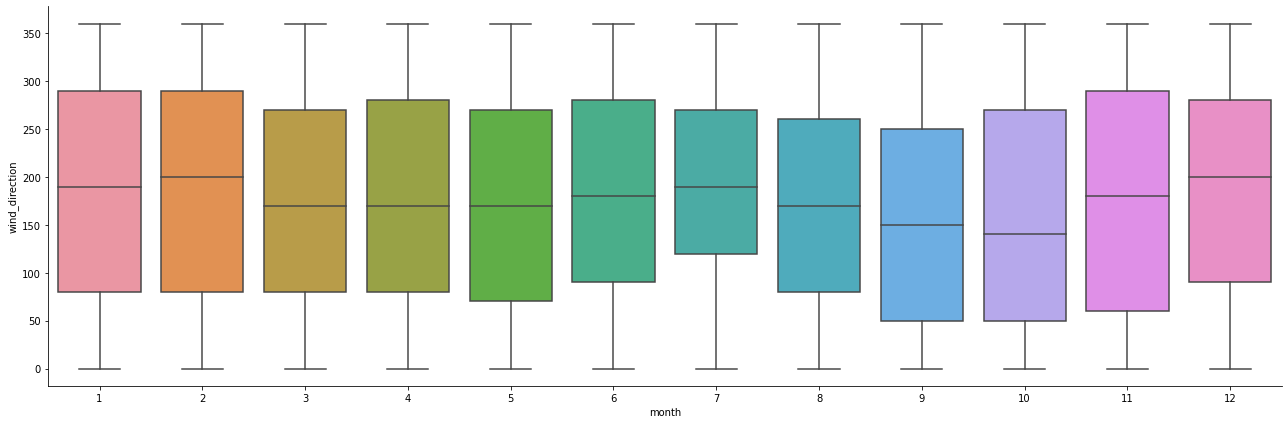

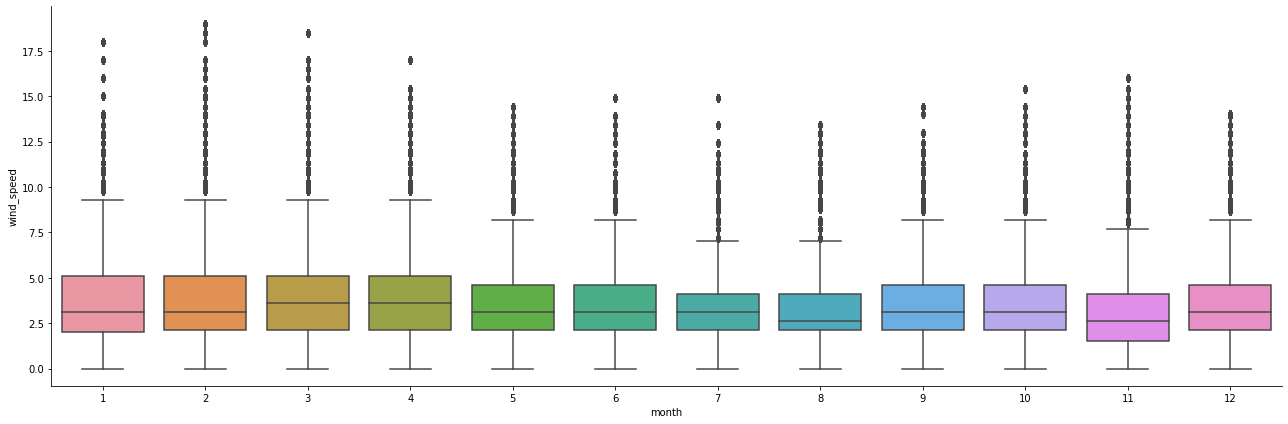

In [41]:
# dependencies of weather variables from month
weather_vars = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
                           'sea_level_pressure', 'wind_direction', 'wind_speed']

for var in weather_vars:
    sns.catplot(x='month', y = var, data=X_train[['month',var]],  kind = 'box', height = 6, aspect = 3)
    plt.tight_layout()

- Air-temperature, dew-temperature highly depend on month (increasing from 5 to 8).
- Highest values of "wind_speed" as weel have an opposite dependency.
- Wind directions slighly changes from 7 to 10 months.
- 'sea_level_pressure' slightly goes downduring 5 till 9 months.
- We don't see as well some not logical otliers among these variables.